## **Hull-White Model: ZCB**

The Hull-White model is a one-factor short-rate model used to describe the evolution of interest rates over time. It is an extension of the Vasicek model and is designed to fit the initial term structure of interest rates.

### **1. Hull-White Model Equation**
The short rate \( r(t) \) in the Hull-White model follows the stochastic differential equation (SDE):

$$
 dr(t) = \lambda (\theta(t) - r(t)) dt + \eta dW(t)
$$

where:
- \( \lambda \) is the mean reversion speed.
- \( \theta(t) \) is a function ensuring the model fits the initial term structure.
- \( \eta \) is the volatility parameter.
- \( W(t) \) is a standard Brownian motion.

### **2. Instantaneous Forward Rate and Theta Function**
The instantaneous forward rate is given by:

$$
 f(0,T) = - \frac{d}{dT} \ln P(0,T)
$$

The function \( \theta(t) \) is derived to ensure that the model is arbitrage-free and fits the observed term structure:

$$
\theta(t) = \frac{1}{\lambda} \left( \frac{d}{dt} f(0,t) \right) + f(0,t) + \frac{\eta^2}{2\lambda^2} (1 - e^{-2\lambda t})
$$

where \( P(0,T) \) is the market zero-coupon bond price.

### **3. Monte Carlo Simulation of the Short Rate**
Using the Euler-Maruyama method, the short rate is simulated as:

$$
 r_{i+1} = r_i + \lambda (\theta(t_i) - r_i) dt + \eta \sqrt{dt} Z_i
$$

where \( Z_i \sim N(0,1) \) is a standard normal random variable.

### **4. Discount Factor and Bond Pricing**
The discount factor process is given by:

$$
 M(t) = \exp \left( \int_0^t r(s) ds \right)
$$

The Monte Carlo estimate of the zero-coupon bond price is computed as:

$$
 P(0,t) = \mathbb{E} \left[ \frac{1}{M(t)} \right]
$$

where the expectation is taken under the risk-neutral measure.

---

## **No-Arbitrage Pricing and Expectation of the Discount Factor**

The fundamental theorem of asset pricing states that under a risk-neutral measure, the price of any tradable asset should be equal to the expected value of its discounted future payoff. For a zero-coupon bond, this implies:

$$
 P(0,T) = \mathbb{E}^{\mathbb{Q}} \left[ \frac{1}{M(T)} \right]
$$

where:
- \( M(T) \) is the stochastic discount factor (numeraire process).
- \( \mathbb{E}^{\mathbb{Q}} \) denotes expectation under the risk-neutral measure.

In our simulation, we compare the bond prices derived from the market with those obtained via Monte Carlo simulation of the Hull-White model.

### **5. Interpretation of the Results**
- The graph compares the market zero-coupon bond curve with the Monte Carlo estimated bond curve.
- The two curves should ideally be close, confirming that the model successfully captures the initial term structure.
- Deviations may occur due to numerical approximation errors and discretization.

This approach ensures that bond prices computed from the model align with market data, preserving no-arbitrage conditions.



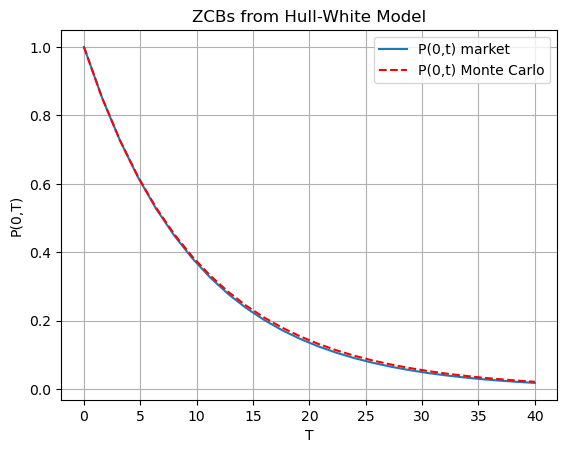

In [3]:


import numpy as np
import matplotlib.pyplot as plt

def f0T(t,P0T):
    # time-step needed for differentiation
    dt = 0.01    
    expr = - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2*dt)
    return expr

def GeneratePathsHWEuler(NoOfPaths,NoOfSteps,T,P0T, lambd, eta):    
    
    # Initial interest rate is a forward rate at time t->0
    r0 = f0T(0.01,P0T)
    theta = lambda t: 1.0/lambd * (f0T(t+dt,P0T)-f0T(t-dt,P0T))/(2.0*dt) + f0T(t,P0T) + eta*eta/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))      
    
    #theta = lambda t: 0.1 +t -t
    #print("changed theta")
    
    Z = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    W = np.zeros([NoOfPaths, NoOfSteps+1])
    R = np.zeros([NoOfPaths, NoOfSteps+1])
    M = np.zeros([NoOfPaths, NoOfSteps+1])
    M[:,0]= 1.0
    R[:,0]= r0
    time = np.zeros([NoOfSteps+1])
        
    dt = T / float(NoOfSteps)
    for i in range(0,NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])
        W[:,i+1] = W[:,i] + np.power(dt, 0.5)*Z[:,i]
        R[:,i+1] = R[:,i] + lambd*(theta(time[i]) - R[:,i]) * dt + eta* (W[:,i+1]-W[:,i])
        M[:,i+1] = M[:,i] * np.exp((R[:,i+1]+R[:,i])*0.5*dt)
        time[i+1] = time[i] +dt
        
    # Outputs
    paths = {"time":time,"R":R,"M":M}
    return paths

def HW_theta(lambd,eta,P0T):
    dt = 0.01    
    theta = lambda t: 1.0/lambd * (f0T(t+dt,P0T)-f0T(t-dt,P0T))/(2.0*dt) + f0T(t,P0T) + eta*eta/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))
    #print("CHANGED THETA")
    return theta#lambda t: 0.1+t-t


def mainCalculation():
    NoOfPaths = 25000
    NoOfSteps = 25
       
    lambd = 0.02
    eta   = 0.02

    # We define a ZCB curve (obtained from the market)
    P0T = lambda T: np.exp(-0.1*T)
       
    # In this experiment we compare ZCB from the Market and Monte Carlo
    "Monte Carlo part"   
    T = 40
    paths= GeneratePathsHWEuler(NoOfPaths,NoOfSteps,T,P0T, lambd, eta)
    M = paths["M"]
    ti = paths["time"]
    #dt = timeGrid[1]-timeGrid[0]
    
    # Here we compare the price of an option on a ZCB from Monte Carlo the Market  
    P_tMC = np.zeros([NoOfSteps+1])
    for i in range(0,NoOfSteps+1):
        P_tMC[i] = np.mean(1.0/M[:,i])
  

    plt.figure(1)
    plt.grid()
    plt.xlabel('T')
    plt.ylabel('P(0,T)')
    plt.plot(ti,P0T(ti))
    plt.plot(ti,P_tMC,'--r')
    plt.legend(['P(0,t) market','P(0,t) Monte Carlo'])
    plt.title('ZCBs from Hull-White Model')
    
mainCalculation()